# Analyse the pyradiomics features

In [1]:
# standard
import pandas as pd
import numpy as np

# fastai
from fastai.tabular import TabularDataBunch, tabular_learner, accuracy, FillMissing, Categorify, Normalize, ClassificationInterpretation, DatasetType, TabularList
from fastai.callbacks import OverSamplingCallback
from fastai.metrics import roc_curve

# personal
from src.utils import get_df_paths, calculate_age, get_df_dis, F_KEY, apply_cat, get_acc, plot_roc_curve, get_advanced_dis_df,apply_cat_ext
from src.utils_radiomics import get_exp_keys, gaussianclassifier, randomforestclassifier, fully_connected_learner

# sklearn
from sklearn import tree, metrics
from sklearn.metrics import auc
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import class_weight

# display
import matplotlib.pyplot as plt
from IPython.display import Image
import pydot

# pyradiomics
import radiomics
radiomics.__version__

'v3.0.1'

# 1. Get datasets without radiomics -> Only age, location and gender dependent

In [3]:
df, _ = get_df_paths()
df_ex, _ = get_df_paths(True)
dis = get_advanced_dis_df(df)
dis_ex = get_advanced_dis_df(df_ex, True)

PATH = 'radiomics'
REM_KEYS = ['Unnamed: 0', 'label2']
DEP_KEY = 'label1'

train = pd.read_csv(f'{PATH}/train.csv')
valid = pd.read_csv(f'{PATH}/valid.csv')
test = pd.read_csv(f'{PATH}/test.csv')
test_external = pd.read_csv(f'{PATH}/test_external.csv')

train = train.fillna(0).drop(columns=REM_KEYS)
valid = valid.fillna(0).drop(columns=REM_KEYS)
test = test.fillna(0).drop(columns=REM_KEYS)
test_external = test_external.fillna(0).drop(columns=REM_KEYS)

dis = get_exp_keys('train', dis)
dis = get_exp_keys('valid', dis)
dis = get_exp_keys('test', dis)
dis_ex = get_exp_keys('test_external', dis_ex)

train = train.fillna(0)
valid = valid.fillna(0)
test_external = test_external.fillna(0)

REM_KEYS = list(train.keys())
REM_KEYS.remove('label1')

ages = get_df_dis(df, out=False)
locs = df['Befundlokalisation']
gend = [name[0] for name in df[F_KEY]]
ent = df['Tumor.Entitaet']

train, valid, test = apply_cat(train, valid, test, dis, 'age', ages)
train, valid, test = apply_cat(train, valid, test, dis, 'loc', locs)
train, valid, test = apply_cat(train, valid, test, dis, 'gen', gend)

ages_ex = get_df_dis(df_ex, out=False, mode=True)
locs_ex = df_ex['Befundlokalisation']
gend_ex = [name[0] for name in df_ex[F_KEY]]
ent_ex = df_ex['Tumor.Entitaet']

test_external = apply_cat_ext(test_external, dis_ex, 'age', ages_ex)
test_external = apply_cat_ext(test_external, dis_ex, 'loc', locs_ex)
test_external = apply_cat_ext(test_external, dis_ex, 'gen', gend_ex)

trainlen = len(train)
print(trainlen)
validlen = len(valid)
print(validlen)

# resulting valid indexes
valid_idx = range(trainlen, trainlen + validlen)

# build df
df_all = train.append(valid)
df_all = df_all.drop(columns=REM_KEYS)
df_train = train
df_test = test_external

# display df
df_all.head()

649
140


,label1,age,loc,gen
0,0,26,Knie,F
1,0,13,Unterschenkel,F
2,0,57,Becken,M
3,0,18,Oberschenkel,M
4,0,19,Unterschenkel,F


In [4]:
# Data Preparation
procs = [FillMissing, Categorify, Normalize]

# continous names
cont_names = list(train.keys())
contl = len(cont_names)
cont_names = cont_names[1:(contl)-5]

# categrorical names
cat_names = ['loc', 'gen', 'age']

# create databunch
data = TabularDataBunch.from_df(
    path=PATH, df=df_all, dep_var=DEP_KEY, valid_idx=valid_idx,
    cat_names=cat_names, cont_names=[], test_df=test, procs=procs)

data_test = TabularDataBunch.from_df(
    path=PATH, df=df_test, dep_var=DEP_KEY, valid_idx=[],
    cat_names= cat_names, cont_names=[], procs=procs)


data.test_ds.x = data_test.train_ds.x
data.test_ds.y = data_test.train_ds.y

# Show databunch
data.train_dl.num_workers = 0
data.train_dl.batch_size = 32
data.show_batch(rows=10)

C:\Users\Niko\anaconda3\lib\site-packages\fastai\data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


loc,gen,age,target
Huefte,M,8,0
Oberschenkel,M,18,0
Unterarm,F,14,0
Oberschenkel,M,25,0
Unterschenkel,F,72,0
Oberschenkel,M,18,0
Becken,F,25,0
Oberarm,M,17,0
Huefte,M,76,1
Becken,M,12,0


C:\Users\Niko\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass indices=[0 0 0 0 ... 0 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
Accuracy: 0.7714285714285715
AUC: 0.7716718266253869


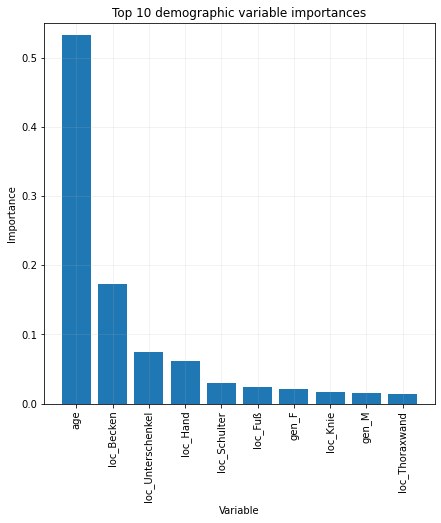

In [5]:
import pydotplus

features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

s_w = class_weight.compute_sample_weight('balanced', np.unique(y), y)
s_wi = [s_w[i] for i in y]

x_test = features[trainlen::]
y_test = label[trainlen::]

lim = 10
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)

# Train Classifier
clf.fit(x, y, sample_weight=s_wi)

# Get accuracy
y_pred = clf.predict(x_test)
p_pred = clf.predict_proba(x_test)[:, 1]
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test, p_pred))

# Analyse features (with lim)
importances = list(clf.feature_importances_)
x_values = list(range(len(importances)))
imp = importances
f_list = feature_list
sort_ind = np.flip(np.argsort(imp, ))
plt.figure(figsize=(7,7))
plt.bar(x_values[:lim], [imp[sort] for sort in sort_ind[:lim]], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values[:lim], [f_list[sort] for sort in sort_ind[:lim]], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(f'Top {lim} demographic variable importances');
plt.ylim([0, 0.55])
plt.grid(alpha=0.2)

# Make graph
tree = clf.estimators_[10] # Import tools needed for visualization
export_graphviz(tree, out_file = 'tree.dot', feature_names=feature_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('tree.dot') # Write graph to a png file
importance_list = [f_list[sort] for sort in sort_ind[:lim]]
Image(graph.create_png())


x_demo_bar = x_values[:lim]
y_demo_bar = [imp[sort] for sort in sort_ind[:lim]]

x_demo_ticks = x_values[:lim]
y_demo_ticks = [f_list[sort] for sort in sort_ind[:lim]]

In [6]:
randomforestclassifier(df_all, DEP_KEY, trainlen)

C:\Users\Niko\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass indices=[0 0 0 0 ... 0 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
AUC: 0.75 +/- 0.01
Accuracy: 0.76 +/- 0.0
Sensitivity: 0.41 +/- 0.01
Specificity: 0.89 +/- 0.0


### 1.2 Gaussian Classifier

In [7]:
gaussianclassifier(df_all, DEP_KEY, trainlen)

AUC: 0.72 +/- 0.0
Accuracy: 0.44 +/- 0.0
Sensitivity: 0.92 +/- 0.0
Specificity: 0.25 +/- 0.0
C:\Users\Niko\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass indices=[0 0 0 0 ... 0 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


### 1.3 Neural Netowrk Classifier

In [ ]:
interp_demographic = fully_connected_learner(data, rounds=20)

# 2. Now only Radiomic features

In [86]:
df, _ = get_df_paths()
df_ex, _ = get_df_paths(True)
dis = get_advanced_dis_df(df)
dis_ex = get_advanced_dis_df(df_ex, True)

PATH = 'radiomics'
REM_KEYS = ['Unnamed: 0', 'label2']
DEP_KEY = 'label1'

train = pd.read_csv(f'{PATH}/train.csv')
valid = pd.read_csv(f'{PATH}/valid.csv')
test = pd.read_csv(f'{PATH}/test.csv')
test_external = pd.read_csv(f'{PATH}/test_external.csv')

train = train.fillna(0).drop(columns=REM_KEYS)
valid = valid.fillna(0).drop(columns=REM_KEYS)
test = test.fillna(0).drop(columns=REM_KEYS)
test_external = test_external.fillna(0).drop(columns=REM_KEYS)

dis = get_exp_keys('train', dis)
dis = get_exp_keys('valid', dis)
dis = get_exp_keys('test', dis)
dis_ex = get_exp_keys('test_external', dis_ex)

train = train.fillna(0)
valid = valid.fillna(0)
test = test.fillna(0)
test_external = test_external.fillna(0)

REM_KEYS = list(train.keys())
REM_KEYS.remove('label1')


trainlen = len(train)
print(trainlen)
validlen = len(valid)
print(validlen)

# resulting valid indexes
valid_idx = range(trainlen, trainlen + validlen)

# build df
df_all = train.append(valid)
df_train = train
df_test = test_external

649
140


In [87]:
df_test.keys() 

Index(['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean',
       'original_firstorder_Median',
       ...
       'wavelet-LLL_firstorder_Median', 'wavelet-LLL_firstorder_Minimum',
       'wavelet-LLL_firstorder_Range',
       'wavelet-LLL_firstorder_RobustMeanAbsoluteDeviation',
       'wavelet-LLL_firstorder_RootMeanSquared',
       'wavelet-LLL_firstorder_Skewness', 'wavelet-LLL_firstorder_TotalEnergy',
       'wavelet-LLL_firstorder_Uniformity', 'wavelet-LLL_firstorder_Variance',
       'label1'],
      dtype='object', length=163)

In [88]:
list_train = list(df_train.keys())
list_test = list(df_test.keys())

commons = list(sorted(list(set(list_train) - (set(list_train) - set(list_test)))))
commons = commons[1::]
commons

['original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_Mean',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Median',
 'original_firstorder_Minimum',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_Skewness',
 'original_firstorder_TotalEnergy',
 'original_firstorder_Uniformity',
 'original_firstorder_Variance',
 'wavelet-HHH_firstorder_10Percentile',
 'wavelet-HHH_firstorder_90Percentile',
 'wavelet-HHH_firstorder_Energy',
 'wavelet-HHH_firstorder_Entropy',
 'wavelet-HHH_firstorder_InterquartileRange',
 'wavelet-HHH_firstorder_Kurtosis',
 'wavelet-HHH_firstorder_Maximum',
 'wavelet-HHH_firstorder_Mean',
 'wavelet-HHH_firstorder_MeanAbsoluteDeviation',
 'wavelet-H

In [89]:
# Data Preparation
procs = [FillMissing, Categorify, Normalize]

train, valid, test = apply_cat(train, valid, test, dis, 'ent', ent)
test_external = apply_cat_ext(test_external, dis_ex, 'ent', ent_ex)

# categrorical names
cat_names = ['loc', 'gen', 'age']

# create databunch
data = TabularDataBunch.from_df(
    path=PATH, df=df_all, dep_var=DEP_KEY, valid_idx=valid_idx,
    cat_names=[], cont_names=commons, test_df=test, procs=procs)

data_test = TabularDataBunch.from_df(
    path=PATH, df=df_test, dep_var=DEP_KEY, valid_idx=[],
    cat_names=[], cont_names=commons, procs=procs)

data.test_ds.x = data_test.train_ds.x
data.test_ds.y = data_test.train_ds.y

# Show databunch
data.train_dl.num_workers = 0
data.train_dl.batch_size = 32
data.show_batch(rows=10)
df_all.head()

C:\Users\Niko\anaconda3\lib\site-packages\fastai\data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,wavelet-HHH_firstorder_10Percentile,wavelet-HHH_firstorder_90Percentile,wavelet-HHH_firstorder_Energy,wavelet-HHH_firstorder_Entropy,wavelet-HHH_firstorder_InterquartileRange,wavelet-HHH_firstorder_Kurtosis,wavelet-HHH_firstorder_Maximum,wavelet-HHH_firstorder_Mean,wavelet-HHH_firstorder_MeanAbsoluteDeviation,wavelet-HHH_firstorder_Median,wavelet-HHH_firstorder_Minimum,wavelet-HHH_firstorder_Range,wavelet-HHH_firstorder_RobustMeanAbsoluteDeviation,wavelet-HHH_firstorder_RootMeanSquared,wavelet-HHH_firstorder_Skewness,wavelet-HHH_firstorder_TotalEnergy,wavelet-HHH_firstorder_Uniformity,wavelet-HHH_firstorder_Variance,wavelet-HHL_firstorder_10Percentile,wavelet-HHL_firstorder_90Percentile,wavelet-HHL_firstorder_Energy,wavelet-HHL_firstorder_Entropy,wavelet-HHL_firstorder_InterquartileRange,wavelet-HHL_firstorder_Kurtosis,wavelet-HHL_firstorder_Maximum,wavelet-HHL_firstorder_Mean,wavelet-HHL_firstorder_MeanAbsoluteDeviation,wavelet-HHL_firstorder_Median,wavelet-HHL_firstorder_Minimum,wavelet-HHL_firstorder_Range,wavelet-HHL_firstorder_RobustMeanAbsoluteDeviation,wavelet-HHL_firstorder_RootMeanSquared,wavelet-HHL_firstorder_Skewness,wavelet-HHL_firstorder_TotalEnergy,wavelet-HHL_firstorder_Uniformity,wavelet-HHL_firstorder_Variance,wavelet-HLH_firstorder_10Percentile,wavelet-HLH_firstorder_90Percentile,wavelet-HLH_firstorder_Energy,wavelet-HLH_firstorder_Entropy,wavelet-HLH_firstorder_InterquartileRange,wavelet-HLH_firstorder_Kurtosis,wavelet-HLH_firstorder_Maximum,wavelet-HLH_firstorder_Mean,wavelet-HLH_firstorder_MeanAbsoluteDeviation,wavelet-HLH_firstorder_Median,wavelet-HLH_firstorder_Minimum,wavelet-HLH_firstorder_Range,wavelet-HLH_firstorder_RobustMeanAbsoluteDeviation,wavelet-HLH_firstorder_RootMeanSquared,wavelet-HLH_firstorder_Skewness,wavelet-HLH_firstorder_TotalEnergy,wavelet-HLH_firstorder_Uniformity,wavelet-HLH_firstorder_Variance,wavelet-HLL_firstorder_10Percentile,wavelet-HLL_firstorder_90Percentile,wavelet-HLL_firstorder_Energy,wavelet-HLL_firstorder_Entropy,wavelet-HLL_firstorder_InterquartileRange,wavelet-HLL_firstorder_Kurtosis,wavelet-HLL_firstorder_Maximum,wavelet-HLL_firstorder_Mean,wavelet-HLL_firstorder_MeanAbsoluteDeviation,wavelet-HLL_firstorder_Median,wavelet-HLL_firstorder_Minimum,wavelet-HLL_firstorder_Range,wavelet-HLL_firstorder_RobustMeanAbsoluteDeviation,wavelet-HLL_firstorder_RootMeanSquared,wavelet-HLL_firstorder_Skewness,wavelet-HLL_firstorder_TotalEnergy,wavelet-HLL_firstorder_Uniformity,wavelet-HLL_firstorder_Variance,wavelet-LHH_firstorder_10Percentile,wavelet-LHH_firstorder_90Percentile,wavelet-LHH_firstorder_Energy,wavelet-LHH_firstorder_Entropy,wavelet-LHH_firstorder_InterquartileRange,wavelet-LHH_firstorder_Kurtosis,wavelet-LHH_firstorder_Maximum,wavelet-LHH_firstorder_Mean,wavelet-LHH_firstorder_MeanAbsoluteDeviation,wavelet-LHH_firstorder_Median,wavelet-LHH_firstorder_Minimum,wavelet-LHH_firstorder_Range,wavelet-LHH_firstorder_RobustMeanAbsoluteDeviation,wavelet-LHH_firstorder_RootMeanSquared,wavelet-LHH_firstorder_Skewness,wavelet-LHH_firstorder_TotalEnergy,wavelet-LHH_firstorder_Uniformity,wavelet-LHH_firstorder_Variance,wavelet-LHL_firstorder_10Percentile,wavelet-LHL_firstorder_90Percentile,wavelet-LHL_firstorder_Energy,wavelet-LHL_firstorder_Entropy,wavelet-LHL_firstorder_InterquartileRange,wavelet-LHL_firstorder_Kurtosis,wavelet-LHL_firstorder_Maximum,wavelet-LHL_firstorder_Mean,wavelet-LHL_firstorder_MeanAbsoluteDeviation

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,log-sigma-3-0-mm-3D_firstorder_Mean,log-sigma-3-0-mm-3D_firstorder_Median,log-sigma-3-0-mm-3D_firstorder_Minimum,log-sigma-3-0-mm-3D_firstorder_Range,log-sigma-3-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation,log-sigma-3-0-mm-3D_firstorder_RootMeanSquared,log-sigma-3-0-mm-3D_firstorder_Skewness,log-sigma-3-0-mm-3D_firstorder_TotalEnergy,log-sigma-3-0-mm-3D_firstorder_Uniformity,log-sigma-3-0-mm-3D_firstorder_Variance
0,15.500020,58.765416,1.308054e+10,4.032506,21.951561,8.831832,174.001975,17.160024,38.396903,34.507913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47.467195,66.612836,4.626589e+08,2.697371,10.327073,5.225828,77.232934,6.350329,56.910082,57.581181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-24.941871,42.195378,1.114753e+10,4.553707,35.356870,7.945965,116.520749,25.008526,4.948465,6.494844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.175243,58.478122,3.331790e+09,3.858980,17.818996,5.631246,88.865517,15.561807,22.142780,18.896396,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.115728,66.987773,6.860790e+09,4.145085,28.682225,18.094700,261.096939,20.500603,33.386308,27.626637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.1 Randomforest Classifier

In [90]:
randomforestclassifier(df_all, DEP_KEY, trainlen)

C:\Users\Niko\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass indices=[0 0 0 0 ... 0 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
AUC: 0.73 +/- 0.01
Accuracy: 0.59 +/- 0.01
Sensitivity: 0.84 +/- 0.02
Specificity: 0.5 +/- 0.01


In [91]:
gaussianclassifier(df_all, DEP_KEY, trainlen)

C:\Users\Niko\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass indices=[0 0 0 0 ... 0 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
AUC: 0.68 +/- 0.0
Accuracy: 0.76 +/- 0.0
Sensitivity: 0.45 +/- 0.0
Specificity: 0.88 +/- 0.0


In [ ]:
fully_connected_learner(data)

# 3. Get datasets with all features

In [98]:
df, _ = get_df_paths()
df_ex, _ = get_df_paths(True)
dis = get_advanced_dis_df(df)
dis_ex = get_advanced_dis_df(df_ex, True)

PATH = 'radiomics'
REM_KEYS = ['Unnamed: 0', 'label2']
DEP_KEY = 'label1'

train = pd.read_csv(f'{PATH}/train.csv')
valid = pd.read_csv(f'{PATH}/valid.csv')
test = pd.read_csv(f'{PATH}/test.csv')
test_external = pd.read_csv(f'{PATH}/test_external.csv')

train = train.fillna(0).drop(columns=REM_KEYS)
valid = valid.fillna(0).drop(columns=REM_KEYS)
test = test.fillna(0).drop(columns=REM_KEYS)
test_external = test_external.fillna(0).drop(columns=REM_KEYS)

dis = get_exp_keys('train', dis)
dis = get_exp_keys('valid', dis)
dis = get_exp_keys('test', dis)
dis_ex = get_exp_keys('test_external', dis_ex)

train = train.fillna(0)
valid = valid.fillna(0)
test_external = test_external.fillna(0)


# build df
df_all = train.append(valid)
df_train = train
df_test = test_external

# continous names
list_train = list(df_train.keys())
list_test = list(df_test.keys())

commons = list(sorted(list(set(list_train) - (set(list_train) - set(list_test)))))
commons = commons[1::]



ages = get_df_dis(df, out=False)
locs = df['Befundlokalisation']
gend = [name[0] for name in df[F_KEY]]
ent = df['Tumor.Entitaet']

train, valid, test = apply_cat(train, valid, test, dis, 'age', ages)
train, valid, test = apply_cat(train, valid, test, dis, 'loc', locs)
train, valid, test = apply_cat(train, valid, test, dis, 'gen', gend)

ages_ex = get_df_dis(df_ex, out=False, mode=True)
locs_ex = df_ex['Befundlokalisation']
gend_ex = [name[0] for name in df_ex[F_KEY]]
ent_ex = df_ex['Tumor.Entitaet']

test_external = apply_cat_ext(test_external, dis_ex, 'age', ages_ex)
test_external = apply_cat_ext(test_external, dis_ex, 'loc', locs_ex)
test_external = apply_cat_ext(test_external, dis_ex, 'gen', gend_ex)

trainlen = len(train)
print(trainlen)
validlen = len(valid)
print(validlen)

# resulting valid indexes
valid_idx = range(trainlen, trainlen + validlen)

# build df
df_all = train.append(valid)
df_train = train
df_test = test_external

# display df
df_all.head()


# Data Preparation
procs = [FillMissing, Categorify, Normalize]




# categrorical names
cat_names = ['loc', 'gen', 'age']

# create databunch
data = TabularDataBunch.from_df(
    path=PATH, df=df_all, dep_var=DEP_KEY, valid_idx=valid_idx,
    cat_names= cat_names, cont_names = commons, test_df=test, procs=procs)

data_test = TabularDataBunch.from_df(
    path=PATH, df=df_test, dep_var=DEP_KEY, valid_idx=[],
    cat_names= cat_names, cont_names = commons, procs=procs)

data.test_ds.x = data_test.train_ds.x
data.test_ds.y = data_test.train_ds.y

# Show databunch
data.train_dl.num_workers = 0
data.train_dl.batch_size = 32
data.show_batch(rows=10)

df_all[DEP_KEY]

649
140
C:\Users\Niko\anaconda3\lib\site-packages\fastai\data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


loc,gen,age,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,wavelet-HHH_firstorder_10Percentile,wavelet-HHH_firstorder_90Percentile,wavelet-HHH_firstorder_Energy,wavelet-HHH_firstorder_Entropy,wavelet-HHH_firstorder_InterquartileRange,wavelet-HHH_firstorder_Kurtosis,wavelet-HHH_firstorder_Maximum,wavelet-HHH_firstorder_Mean,wavelet-HHH_firstorder_MeanAbsoluteDeviation,wavelet-HHH_firstorder_Median,wavelet-HHH_firstorder_Minimum,wavelet-HHH_firstorder_Range,wavelet-HHH_firstorder_RobustMeanAbsoluteDeviation,wavelet-HHH_firstorder_RootMeanSquared,wavelet-HHH_firstorder_Skewness,wavelet-HHH_firstorder_TotalEnergy,wavelet-HHH_firstorder_Uniformity,wavelet-HHH_firstorder_Variance,wavelet-HHL_firstorder_10Percentile,wavelet-HHL_firstorder_90Percentile,wavelet-HHL_firstorder_Energy,wavelet-HHL_firstorder_Entropy,wavelet-HHL_firstorder_InterquartileRange,wavelet-HHL_firstorder_Kurtosis,wavelet-HHL_firstorder_Maximum,wavelet-HHL_firstorder_Mean,wavelet-HHL_firstorder_MeanAbsoluteDeviation,wavelet-HHL_firstorder_Median,wavelet-HHL_firstorder_Minimum,wavelet-HHL_firstorder_Range,wavelet-HHL_firstorder_RobustMeanAbsoluteDeviation,wavelet-HHL_firstorder_RootMeanSquared,wavelet-HHL_firstorder_Skewness,wavelet-HHL_firstorder_TotalEnergy,wavelet-HHL_firstorder_Uniformity,wavelet-HHL_firstorder_Variance,wavelet-HLH_firstorder_10Percentile,wavelet-HLH_firstorder_90Percentile,wavelet-HLH_firstorder_Energy,wavelet-HLH_firstorder_Entropy,wavelet-HLH_firstorder_InterquartileRange,wavelet-HLH_firstorder_Kurtosis,wavelet-HLH_firstorder_Maximum,wavelet-HLH_firstorder_Mean,wavelet-HLH_firstorder_MeanAbsoluteDeviation,wavelet-HLH_firstorder_Median,wavelet-HLH_firstorder_Minimum,wavelet-HLH_firstorder_Range,wavelet-HLH_firstorder_RobustMeanAbsoluteDeviation,wavelet-HLH_firstorder_RootMeanSquared,wavelet-HLH_firstorder_Skewness,wavelet-HLH_firstorder_TotalEnergy,wavelet-HLH_firstorder_Uniformity,wavelet-HLH_firstorder_Variance,wavelet-HLL_firstorder_10Percentile,wavelet-HLL_firstorder_90Percentile,wavelet-HLL_firstorder_Energy,wavelet-HLL_firstorder_Entropy,wavelet-HLL_firstorder_InterquartileRange,wavelet-HLL_firstorder_Kurtosis,wavelet-HLL_firstorder_Maximum,wavelet-HLL_firstorder_Mean,wavelet-HLL_firstorder_MeanAbsoluteDeviation,wavelet-HLL_firstorder_Median,wavelet-HLL_firstorder_Minimum,wavelet-HLL_firstorder_Range,wavelet-HLL_firstorder_RobustMeanAbsoluteDeviation,wavelet-HLL_firstorder_RootMeanSquared,wavelet-HLL_firstorder_Skewness,wavelet-HLL_firstorder_TotalEnergy,wavelet-HLL_firstorder_Uniformity,wavelet-HLL_firstorder_Variance,wavelet-LHH_firstorder_10Percentile,wavelet-LHH_firstorder_90Percentile,wavelet-LHH_firstorder_Energy,wavelet-LHH_firstorder_Entropy,wavelet-LHH_firstorder_InterquartileRange,wavelet-LHH_firstorder_Kurtosis,wavelet-LHH_firstorder_Maximum,wavelet-LHH_firstorder_Mean,wavelet-LHH_firstorder_MeanAbsoluteDeviation,wavelet-LHH_firstorder_Median,wavelet-LHH_firstorder_Minimum,wavelet-LHH_firstorder_Range,wavelet-LHH_firstorder_RobustMeanAbsoluteDeviation,wavelet-LHH_firstorder_RootMeanSquared,wavelet-LHH_firstorder_Skewness,wavelet-LHH_firstorder_TotalEnergy,wavelet-LHH_firstorder_Uniformity,wavelet-LHH_firstorder_Variance,wavelet-LHL_firstorder_10Percentile,wavelet-LHL_firstorder_90Percentile,wavelet-LHL_firstorder_Energy,wavelet-LHL_firstorder_Entropy,wavelet-LHL_firstorder_InterquartileRange,wavelet-LHL_firstorder_Kurtosis,wavelet-LHL_firstorder_Maximum,wavelet-LHL_firstorder_Mean,wavelet-LHL_firstorder_MeanAbsol

0      0
1      0
2      0
3      0
4      0
      ..
135    0
136    0
137    0
138    0
139    0
Name: label1, Length: 789, dtype: int64

### 3.1 Random Forest Classifier

Accuracy: 0.7428571428571429
AUC: 0.7445820433436532


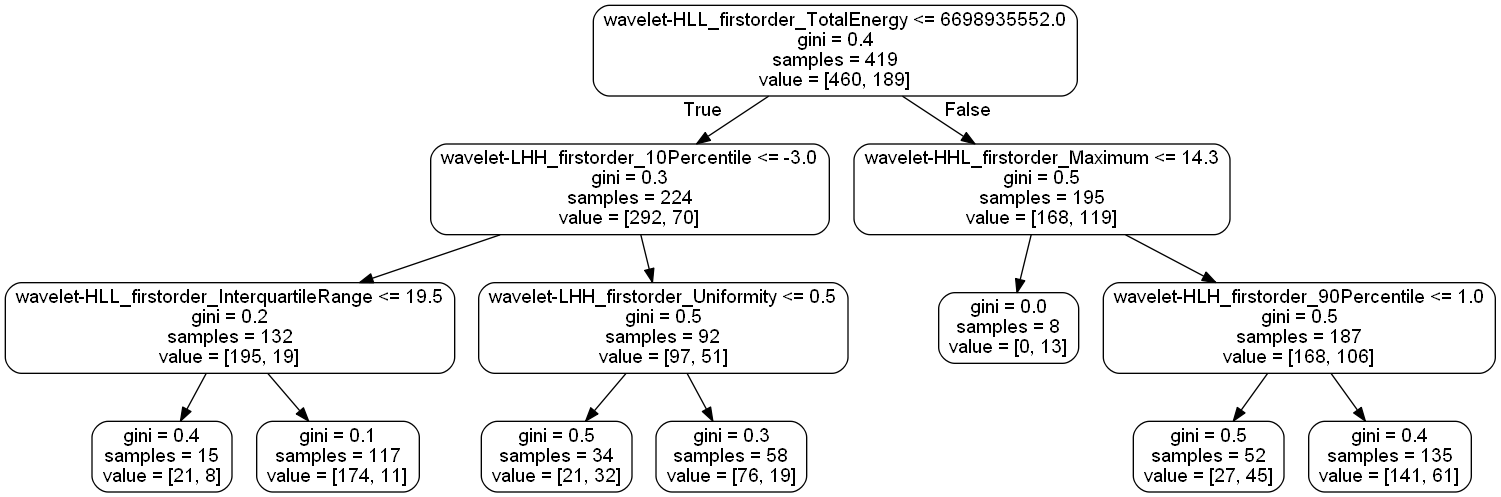

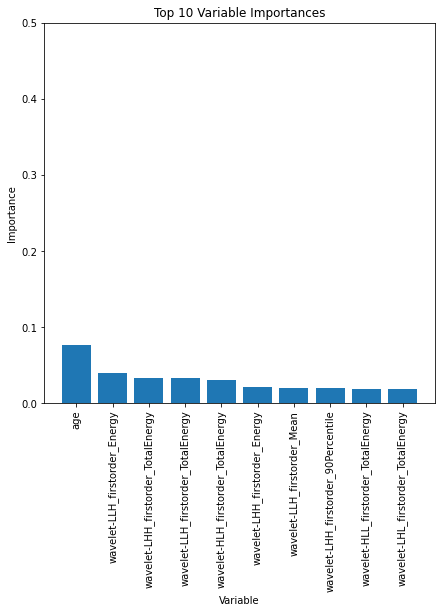

In [99]:
import pydotplus

features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

x_test = features[trainlen::]
y_test = label[trainlen::]

lim = 10
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)

# Train Classifier
clf.fit(x, y)

# Get accuracy
y_pred = clf.predict(x_test)
p_pred = clf.predict_proba(x_test)[:, 1]
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test, p_pred))

# Analyse features (with lim)
importances = list(clf.feature_importances_)
x_values = list(range(len(importances)))
imp = importances
f_list = feature_list
sort_ind = np.flip(np.argsort(imp, ))
plt.figure(figsize=(7,7))
plt.bar(x_values[:lim], [imp[sort] for sort in sort_ind[:lim]], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values[:lim], [f_list[sort] for sort in sort_ind[:lim]], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(f'Top {lim} Variable Importances');
plt.ylim([0, 0.5])

# Make graph
tree = clf.estimators_[10] # Import tools needed for visualization
export_graphviz(tree, out_file = 'tree.dot', feature_names=feature_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('tree.dot') # Write graph to a png file
importance_list = [f_list[sort] for sort in sort_ind[:lim]]
Image(graph.create_png())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


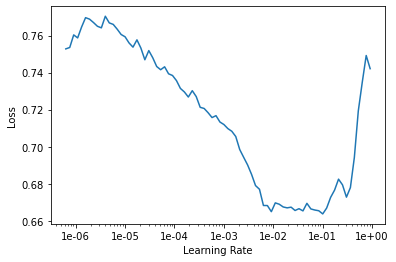

In [100]:
import torch
learn = tabular_learner(data, layers=[200,100,100], metrics=accuracy, callback_fns=[OverSamplingCallback])
learn.lr_find()
learn.recorder.plot()

In [102]:
# apply label balancing
labels = learn.data.train_dl.y.items
_, label_counts = np.unique(labels,return_counts=True)
redux = int(np.min(label_counts) * 0.5)
label_counts[0] = label_counts[0] + redux
label_counts[1] = label_counts[1] - redux
weights = torch.DoubleTensor((1/label_counts)[labels])
total_len_oversample = int(learn.data.c*np.max(label_counts))
total_len_oversample

1114

In [103]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.687121,0.747807,0.485714,01:25
1,0.627179,0.719847,0.664286,01:08
2,0.555302,0.706603,0.614286,01:45
3,0.511564,0.675284,0.628571,01:13
4,0.453808,0.753846,0.678571,01:08
5,0.421883,0.713985,0.678571,01:13
6,0.378704,0.751949,0.685714,01:12
7,0.325232,0.768753,0.721429,01:16
8,0.265920,0.768189,0.742857,01:16
9,0.235149,0.779293,0.764286,01:15


In [104]:
cm = interp.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')

NameError: name 'interp' is not defined